In [1]:
import cv2
import warnings
import numpy as np
import pandas as pd
from skimage import feature
from itertools import product
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata, interp1d


import scanreader
import static_nda as nda
from stimline import tune
from stimulus import stimulus
from pipeline.utils import h5,caiman_interface
from pipeline import meso, experiment, stack, collection

import datajoint as dj
anat = dj.create_virtual_module('anatomy', 'pipeline_anatomy')
maps = dj.create_virtual_module('maps','pipeline_map')

Loading local settings from pipeline_config.json
Connecting pfahey@at-database.ad.bcm.edu:3306
Bokeh could not be loaded. Either it is not installed or you are not running within a notebook
numba not found


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

# Monitor Specs

In [2]:
# Display Viewing Area(HxV) : 565.0 x 330.7 mm
# Measured display area: (22 + 3/16) * 2.54, 12.5 * 2.54
# w,h = 55.3,31.1 # assumed specs for monitor diagonal (25 in)


d = 15 # centimeters from eye to screen
w,h = 56.5,31.8 # full width and height of screen in centimeters

theta = np.deg2rad(90) #angle of screen relative to eye, 90 is tangent to the nearest surface of the eye

def eye2loc(x):
    ## distance from eye to screen location at x cm according to law of cosines
    c = np.sqrt(d**2 + x**2 - 2*d*x*np.cos(theta))
    return c

def dist2deg(x):
    ## visual angle from nearest point to location at x cm according to line of sines
    a = np.arcsin(np.sin(theta)*x/eye2loc(x))
    a = np.rad2deg(a)
    return a

def two_point_dist(x1,x2):
    ## visual angle between two monitor points at x1,x2 cm from the center
    print('angle to location 1: ',dist2deg(x1))
    print('angle to location 2: ',dist2deg(x2))
    print('absolute angular distance between two points: ',np.abs(dist2deg(x2) - dist2deg(x1)))


print('\nangular width of monitor if perfectly centered and perpendicular')
two_point_dist(-w/2,w/2)

print('\nangular height of monitor if perfectly cenetered and perpendicular')
two_point_dist(-h/2,h/2)

print('\nangular diameter of 1 cm at nearest point')
x1 = -0.5
x2 = 0.5
two_point_dist(x1,x2)

print('\nangular diameter of 1 cm at most remote point')
farthest = ((w/2)**2 + (h/2)**2)**0.5
x1 = (farthest-0.5)
x2 = (farthest+0.5)
two_point_dist(x1,x2)



angular width of monitor if perfectly centered and perpendicular
angle to location 1:  -62.032884493880616
angle to location 2:  62.032884493880616
absolute angular distance between two points:  124.06576898776123

angular height of monitor if perfectly cenetered and perpendicular
angle to location 1:  -46.66833744829331
angle to location 2:  46.668337448293315
absolute angular distance between two points:  93.33667489658663

angular diameter of 1 cm at nearest point
angle to location 1:  -1.9091524329963767
angle to location 2:  1.9091524329963767
absolute angular distance between two points:  3.8183048659927534

angular diameter of 1 cm at most remote point
angle to location 1:  64.82804423538926
angle to location 2:  65.50175223568995
absolute angular distance between two points:  0.6737080003006923


# Dotmapping Scan

In [32]:
unique_atts = list(stimulus.SingleDot.heading)
shared_atts = unique_atts.copy()[1:]
shared_atts.remove('dot_x')
shared_atts.remove('dot_y')

dot_rest = 'scan_purpose = "ROI_dotmapping" and study_name = "imagenet_V1"'
data_sessions = dj.U('animal_id','session') & nda.Scan()
cur_dot_rel = collection.CuratedScan() & data_sessions & dot_rest
dot_params = (dj.U('animal_id','session','scan_idx',*shared_atts) & 
              ((stimulus.Trial & cur_dot_rel) * stimulus.SingleDot))

recast_shared_atts = (dj.U(*shared_atts) & dot_params.proj(dot_xsize='CAST(dot_xsize AS DECIMAL(3,2))',
                                                           dot_ysize='CAST(dot_ysize AS DECIMAL(3,2))',
                                                           dot_time ='CAST(dot_time AS DECIMAL(3,2))'))
recast_singledot = stimulus.SingleDot.proj(*unique_atts,
                                           dot_xsize='CAST(dot_xsize AS DECIMAL(3,2))',
                                           dot_ysize='CAST(dot_ysize AS DECIMAL(3,2))',
                                           dot_time ='CAST(dot_time AS DECIMAL(3,2))')

print('Two dotmapping stimulus protocols were applied across the 7 animals, with no one policy applied across all 7')
for recast_shared_att in recast_shared_atts:
    display(recast_shared_atts & recast_shared_att)
    recast_att_rel = (((stimulus.Trial & cur_dot_rel) * recast_singledot) & recast_shared_att)
    x_set,y_set = [set([tuple(sorted(set((recast_att_rel & dot_key).fetch(k)))) 
                    for dot_key in cur_dot_rel & recast_att_rel]) for k in ['dot_x','dot_y']]
    n_conds = set([len(dj.U(*unique_atts) & (recast_att_rel & dot_key)) for dot_key in cur_dot_rel & recast_att_rel])
    n_repeats = set([tuple(set(dj.U(*unique_atts).aggr(recast_att_rel & dot_key,
                                                       n_trials='count(*)').fetch('n_trials')))
                     for dot_key in cur_dot_rel & recast_att_rel])
    
    assert len(x_set) == 1
    assert len(y_set) == 1
    assert len(n_conds) == 1
    assert len(n_repeats) == 1
    x_set = list(x_set)[0]
    y_set = list(y_set)[0]
    n_conds = list(n_conds)[0]
    n_repeats = list(n_repeats)[0]
    
    print('grid x ', len(x_set), ' positions ',x_set)
    print('\ngrid y ', len(y_set), ' positions ',y_set)
    print('\nconditions: ', n_conds)
    print('\ntrials per condition: ', n_repeats)
    
    mon_aspect = 1.78
    xsize,ysize = float(recast_shared_att['dot_xsize']),float(recast_shared_att['dot_ysize'])
    xmin = np.max((np.min(x_set) - xsize/2,-0.5)) * w
    xmax = np.min((np.max(x_set) + xsize/2,0.5)) * w
    ymax = np.min((np.max(y_set)*mon_aspect + (ysize*mon_aspect)/2,0.5)) * h
    ymin = np.max((np.min(y_set)*mon_aspect - (ysize*mon_aspect)/2,-0.5)) * h 

    print('\nangular width of gridded area')
    two_point_dist(xmin,xmax)

    print('\nangular height of gridded area')
    two_point_dist(ymin,ymax)

print('\n\n\nOptimal dotmapping scans were recorded by Taliah')
display(pd.DataFrame((cur_dot_rel * dot_params).fetch(as_dict=True)))




    


Two dotmapping stimulus protocols were applied across the 7 animals, with no one policy applied across all 7


"bg_level (0-255) the index of the background luminance, 0 is black","dot_level (0-255) the index of the dot luminance, 0 is black",dot_xsize calculated attribute,dot_ysize calculated attribute,dot_shape shape of the dot,dot_time calculated attribute
254,1,0.05,0.05,rect,0.30


grid x  10  positions  (-0.25, -0.194444, -0.138889, -0.0833333, -0.0277778, 0.0277778, 0.0833333, 0.138889, 0.194444, 0.25)

grid y  10  positions  (-0.25, -0.194444, -0.138889, -0.0833333, -0.0277778, 0.0277778, 0.0833333, 0.138889, 0.194444, 0.25)

conditions:  100

trials per condition:  (10,)

angular width of gridded area
angle to location 1:  -46.00837664401536
angle to location 2:  46.00837664401537
absolute angular distance between two points:  92.01675328803073

angular height of gridded area
angle to location 1:  -46.061026203017654
angle to location 2:  46.06102620301767
absolute angular distance between two points:  92.12205240603532


"bg_level (0-255) the index of the background luminance, 0 is black","dot_level (0-255) the index of the dot luminance, 0 is black",dot_xsize calculated attribute,dot_ysize calculated attribute,dot_shape shape of the dot,dot_time calculated attribute
254,1,0.10,0.10,rect,0.20


grid x  8  positions  (-0.4, -0.285714, -0.171429, -0.0571429, 0.0571429, 0.171429, 0.285714, 0.4)

grid y  5  positions  (-0.25, -0.125, 0.0, 0.125, 0.25)

conditions:  40

trials per condition:  (20,)

angular width of gridded area
angle to location 1:  -59.460648887287945
angle to location 2:  59.460648887287945
absolute angular distance between two points:  118.92129777457589

angular height of gridded area
angle to location 1:  -46.66833744829331
angle to location 2:  46.668337448293315
absolute angular distance between two points:  93.33667489658663



Optimal dotmapping scans were recorded by Taliah


,study_name,animal_id,session,scan_idx,scan_purpose,score_ts,bg_level,dot_level,dot_xsize,dot_ysize,dot_shape,dot_time,username,score,notes
0,imagenet_V1,21067,9,13,ROI_dotmapping,2021-09-02 16:21:44,254,1,0.05,0.05,rect,0.3,taliah,5,dotmapfine
1,imagenet_V1,21067,9,18,ROI_dotmapping,2021-09-08 19:26:15,254,1,0.10,0.10,rect,0.2,taliah,5,dotmap
2,imagenet_V1,21067,10,17,ROI_dotmapping,2021-09-02 16:21:44,254,1,0.05,0.05,rect,0.3,taliah,5,dotmapfine
3,imagenet_V1,21067,13,7,ROI_dotmapping,2021-09-02 16:21:44,254,1,0.05,0.05,rect,0.3,taliah,5,dotmapfine
4,imagenet_V1,22620,4,13,ROI_dotmapping,2021-09-02 16:21:44,254,1,0.05,0.05,rect,0.3,taliah,5,dotmapfine
5,imagenet_V1,22620,4,22,ROI_dotmapping,2021-09-02 16:21:44,254,1,0.05,0.05,rect,0.3,taliah,5,dotmap
6,imagenet_V1,22620,5,5,ROI_dotmapping,2021-09-02 16:21:44,254,1,0.10,0.10,rect,0.2,taliah,5,dotmap
7,imagenet_V1,22620,5,9,ROI_dotmapping,2021-09-02 16:21:44,254,1,0.05,0.05,rect,0.3,taliah,5,dotmapfine
8,imagenet_V1,22846,2,18,ROI_dotmapping,2021-09-02 16:21:44,254,1,0.05,0.05,rect,0.3,taliah,5,dotmapfine
9,imagenet_V1,22846,2,22,ROI_dotmapping,2021-09-02 16:21:44,254,1,0.10,0.10,rect,0.2,taliah,5,dotmap


In [10]:
def gen_dotmap_dataframe(dot_keys):
    dotmap_dicts = []
    for dot_key in dot_keys:
        dotmap_dict = dot_key.copy()
        print('fetching scan') # fetches scan and averages 
        scan_filenames = (experiment.Scan & dot_key).local_filenames_as_wildcard
        scan = scanreader.read_scan(scan_filenames) # for mesoscope, returns (fields x pixel_height x pixel_width x channel x frame) matrix, vertically concatenating all scan fields in the same plane
        av_scan = np.average(scan,(0,1,2,3)) # average across all depths, pixels, and channels per frame
        dotmap_dict['av_scan'] = av_scan


        print('deconvolving scan')
        warnings.filterwarnings("ignore")
        deconvolved_scan,_ = caiman_interface.deconvolve(av_scan)
        dotmap_dict['deconvolved_scan'] = deconvolved_scan

        print('fetching_dots')
        dot_rel = (stimulus.Trial & dot_key) * stimulus.SingleDot

        xs,xsizes,ys,ysizes = dot_rel.fetch('dot_x','dot_xsize','dot_y','dot_ysize')

        x_set = sorted(list(set(xs))) #ordered set of x dot coordinates (low to high = left to right)
        y_set = sorted(list(set(ys))) #ordered set of y dot coordinates (low to high = top to bottom)
        x_num,y_num = len(x_set),len(y_set)
        x_mat,y_mat = np.meshgrid(x_set,y_set)

        xsize = list(set(xsizes))
        ysize = list(set(ysizes))
        assert len(xsize) == 1
        assert len(ysize) == 1
        xsize = xsize[0]
        ysize = ysize[0]

        dotmap_dict.update({'x_set':x_set,'y_set':y_set,'x_size':xsize,'y_size':ysize})

        print('syncing trace')
        stim_sync = (stimulus.Sync & dot_key).fetch1('frame_times')
        nfields,fps = (meso.ScanInfo & dot_key).fetch1('nfields','fps')
        s2f = interp1d(stim_sync.squeeze(),np.arange(np.size(stim_sync))/(nfields)) #frame to stimulus clock
        dotmap_dict['fps'] = fps

        print('computing stas')
        stim_stack = []
        for y,x in product(y_set,x_set):
            x_restrict = f'dot_x > {x - 0.01} and dot_x < {x + 0.01}'
            y_restrict = f'dot_y > {y - 0.01} and dot_y < {y + 0.01}'
            flip_times = (dot_rel & x_restrict & y_restrict).fetch('flip_times')
            stim_trace = np.zeros_like(deconvolved_scan)
            for flip_time in flip_times[1:]:
                flip_time = np.round(s2f(flip_time[0])).astype(int)
                stim_trace[flip_time[0]:flip_time[1]] = np.ones(np.diff(flip_time))
            stim_stack.append(stim_trace)
        stim_stack = np.vstack(stim_stack)

    #     max_time = 0.217
    #     num_lags = int(np.ceil((max_time * fps)/5) * 5)
        num_lags = 5
        num_timepoints = stim_stack.shape[-1] - (num_lags - 1) # length of movie minus lag time
        weighted_sums = [np.tensordot(deconvolved_scan[..., lag:lag + num_timepoints], stim_stack[..., :num_timepoints],
                                      axes=(-1, -1)) for lag in range(num_lags)]
        stas = np.stack(weighted_sums, -1) / num_timepoints # num_traces x height x width x num_lags
        stas = [np.vstack([sta[i:i+len(x_set)] for i in len(x_set) * np.arange(len(y_set))]) for sta in stas.T]
        dotmap_dict['num_lags'] = num_lags
        dotmap_dict['times'] = np.round(np.arange(num_lags+1) * 1/fps,3)
        dotmap_dict['stas'] = stas

        print('projecting dots to monitor')
        mon_width = 55.3 # width of monitor in centimeters
        mon_rel = experiment.DisplayGeometry() & 'animal_id = 18765 and session = 4'
        mon_aspect = float(mon_rel.fetch1('monitor_aspect'))

        y_mat_size = 1000
        x_mat_size = int(y_mat_size * mon_aspect)
        mat = np.full((y_mat_size,x_mat_size),np.nan)

        def dot2mon(dot_images):
            mon_images = []
            for dot_image in dot_images:
                mon_mat = mat.copy()
                for (y,x),resp in zip(product(y_set,x_set), np.hstack(dot_image)):
                    xmin = int((np.max((x - xsize/2,-0.5))+0.5)*x_mat_size)
                    xmax = int((np.min((x + xsize/2,0.5))+0.5)*x_mat_size)
                    ymax = int((np.min((y*mon_aspect + (ysize*mon_aspect)/2,0.5))+0.5)*y_mat_size)
                    ymin = int((np.max((y*mon_aspect - (ysize*mon_aspect)/2,-0.5))+0.5)*y_mat_size)
                    mon_mat[ymin:ymax,xmin:xmax] = np.full((np.abs(ymax-ymin),np.abs(xmax-xmin)),resp)
                mon_images.append(mon_mat)
            return mon_images

        stas = dot2mon(stas)
        dotmap_dict['sta_ims'] = stas
        dotmap_dicts.append(dotmap_dict)
    dotmap_df = pd.DataFrame(dotmap_dicts)
    dotmap_df.to_pickle('dotmap_df.pkl')


In [5]:
# gen_dotmap_dataframe(cur_dot_rel.fetch('KEY'))

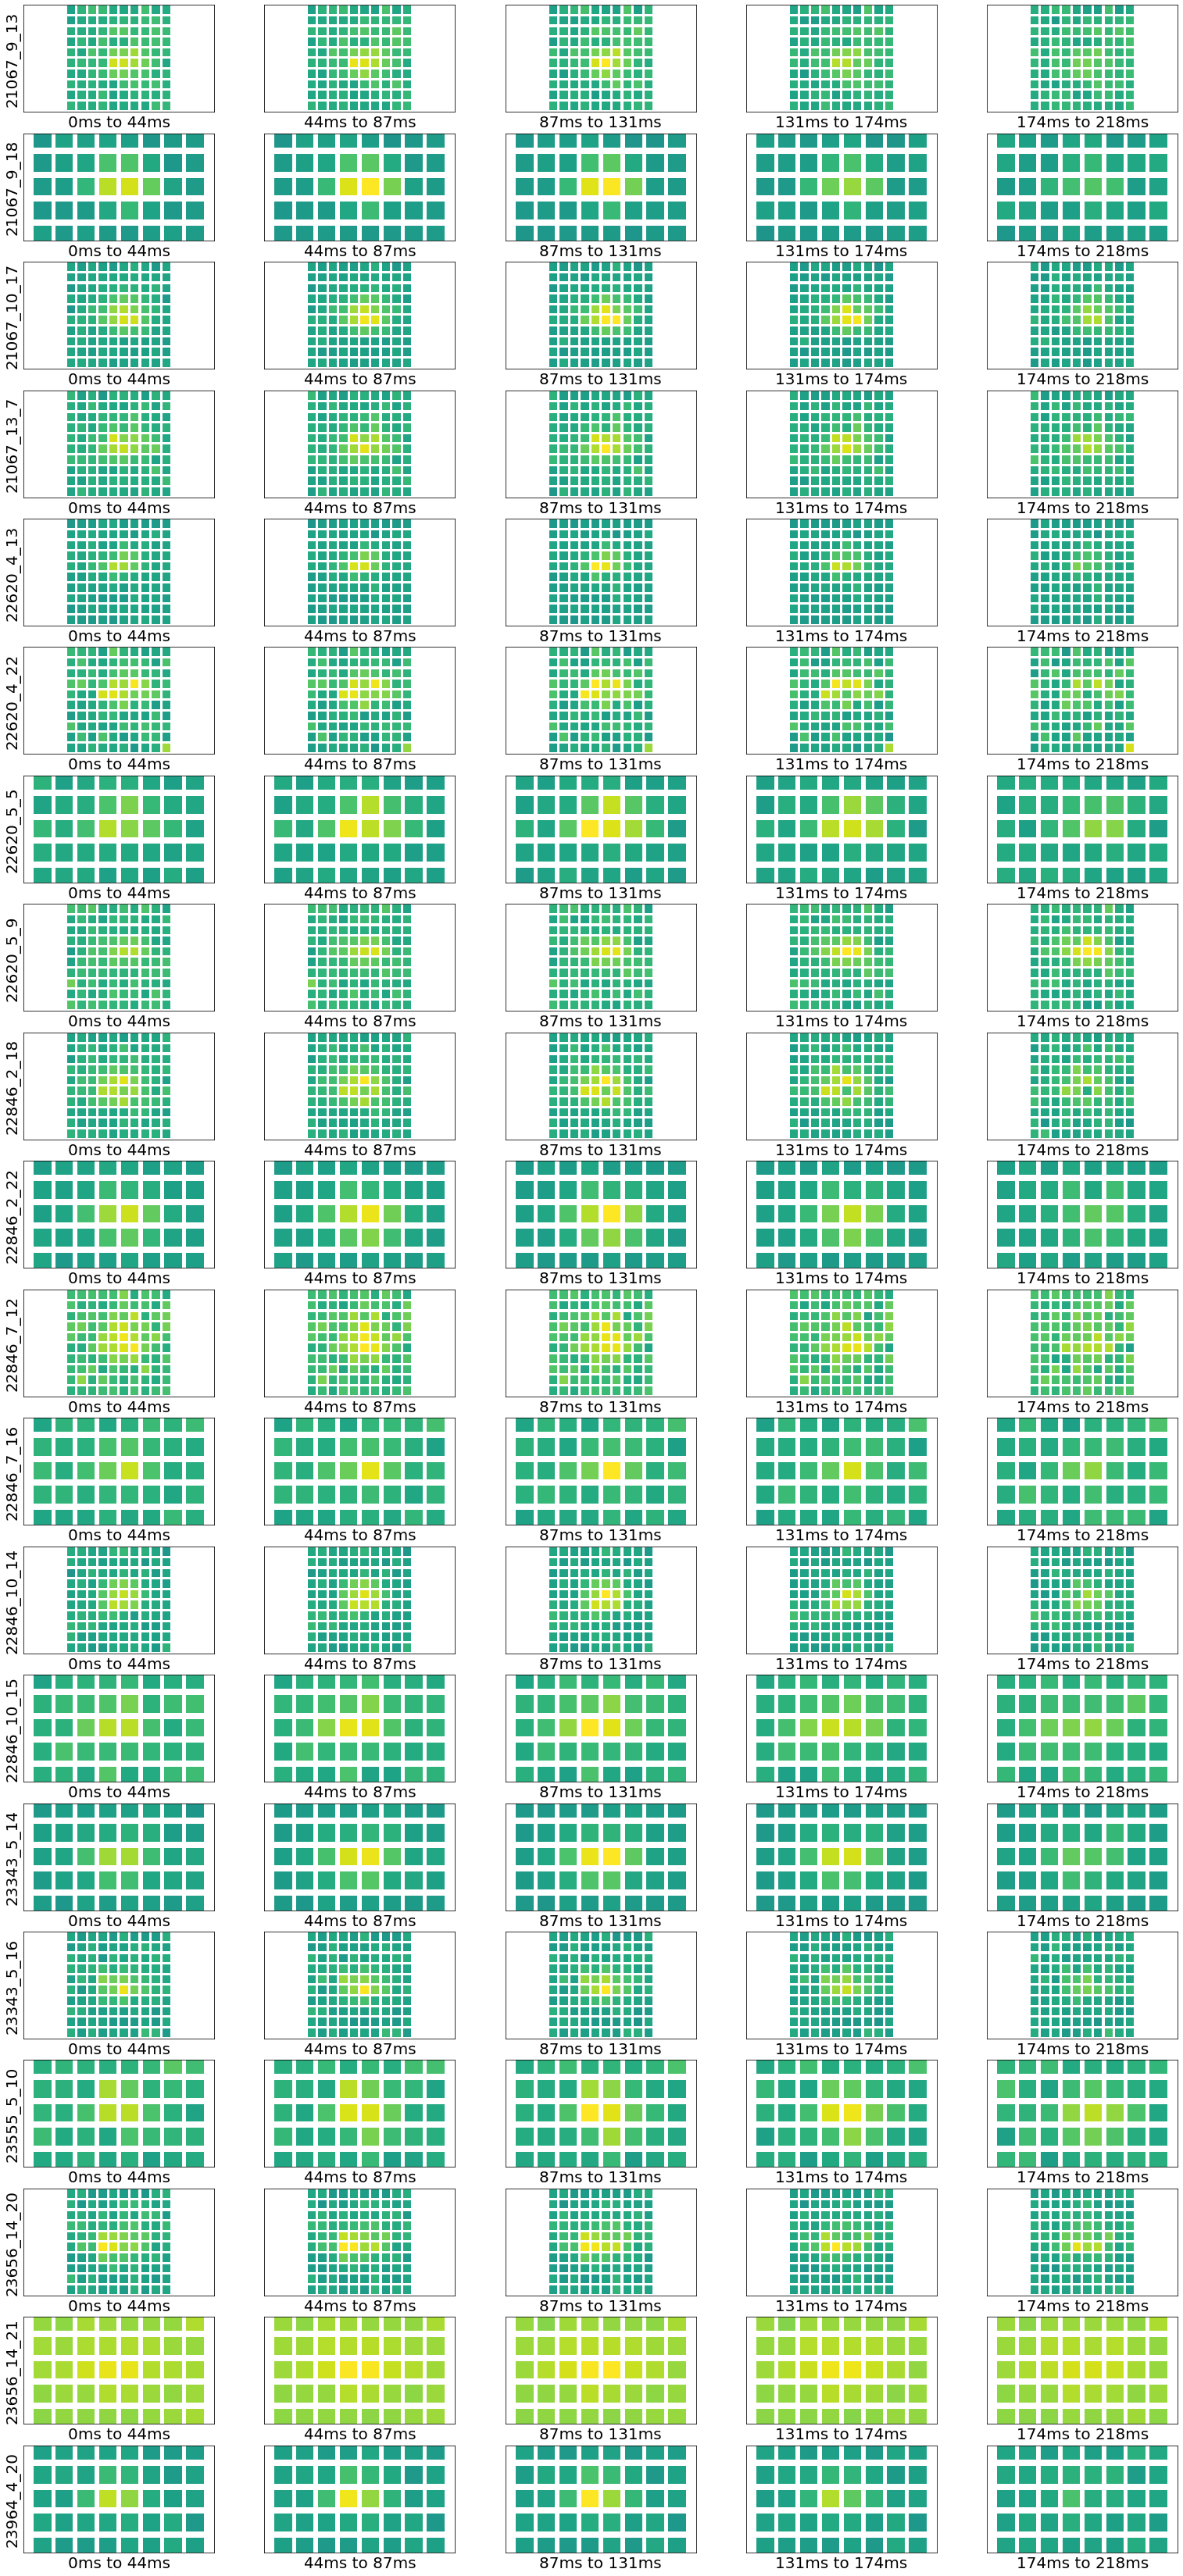

In [6]:
dotmap_df = pd.read_pickle('dotmap_df.pkl')
num_lags = np.shape(np.vstack(dotmap_df['times']))[1]-1

r,c = len(dotmap_df),num_lags
fig,axes_set = plt.subplots(r,c,figsize = (c*3*1.78, r*3))
for sta_ims,times,scan_label,axes in zip(dotmap_df['sta_ims'],dotmap_df['times'],
                                         np.array(dotmap_df[['animal_id','session','scan_idx']]),
                                         axes_set):
    sta_max = np.nanmax(np.abs(sta_ims))
    for sta_im,ax,t0,t1 in zip(sta_ims,axes,times[:-1],times[1:]):
        ax.imshow(sta_im,vmin=-sta_max,vmax=sta_max)
        ax.set_xlabel(str(int(t0*1000))+'ms to ' + str(int(t1*1000)) + 'ms',fontsize=20)
    axes[0].set_ylabel('_'.join([str(s) for s in scan_label]),fontsize=20)
for ax in axes_set.ravel():
    ax.set_aspect('equal')
    ax.set_yticks([])
    ax.set_xticks([])
plt.show()
plt.close()
